In [1]:
import pandas as pd
import os
from typing import List, Sequence, Optional
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from statsmodels.formula.api import ols
import re
from backend.cuentas_nacionales.pib import PIBViews
from backend.cuentas_nacionales.pib.pib_constantes import ConstantesPIB as C
from backend.political_terms import tag_politics
from backend.plots import plot_timeseries_bars, plot_bar_subplots_by_administration

In [2]:
def compute_basic_statistics(df, value_col="PIB_TC", groupby_col="Label"):
    stats = (
        df.groupby(groupby_col)[value_col]
        .agg(
            mean="mean",
            median="median",
            std="std",
            min="min",
            p25=lambda x: x.quantile(0.25),
            p75=lambda x: x.quantile(0.75),
            max="max",
            count="count"
        )
    )
    return stats

In [3]:
from typing import List, Dict, Optional, Tuple

def create_bar_trace(x_values: List[str], y_values: List[float], name: str, color: Optional[str] = None, showlegend: bool = True) -> go.Bar:
    """Creates a single bar trace for a grouped bar chart with an optional color."""
    return go.Bar(x=x_values, y=y_values, name=name, marker_color=color, showlegend=showlegend)

def configure_layout(fig: go.Figure, title: Optional[str] = None, x_title: Optional[str] = None, 
                      y_title: Optional[str] = None, barmode: str = 'group', y_round: int = 0,
                      width: Optional[int] = None, height: Optional[int] = None) -> None:
    """Configures the layout of the figure, including size, format, and Y-axis tick formatting."""
    layout = {
        "barmode": barmode,
        "title": title,
        "xaxis_title": x_title,
        "yaxis_title": y_title,
        "legend": {"orientation": "h", "yanchor": "bottom", "y": -0.2, "xanchor": "center", "x": 0.5},
        "yaxis": {"tickformat": ",.{0}f".format(y_round)},
        "width": width,
        "height": height
    }
    
    fig.update_layout({k: v for k, v in layout.items() if v is not None})

def plot_grouped_bars(data: Dict[str, List[float]], categories: List[str], 
                       title: Optional[str] = None, x_title: Optional[str] = None, 
                       y_title: Optional[str] = None, barmode: str = 'group', 
                       y_round: int = 0, colors: Optional[List[str]] = None,
                       width: Optional[int] = None, height: Optional[int] = None,
                       showlegend: bool = True) -> go.Figure:
    """Creates and returns a grouped bar chart figure with customizable colors, size, and Y-axis formatting."""
    fig = go.Figure()
    color_map = colors if colors and len(colors) >= len(data) else [None] * len(data)
    
    for i, ((group_name, y_values), color) in enumerate(zip(data.items(), color_map)):
        fig.add_trace(create_bar_trace(categories, y_values, group_name, color, showlegend=showlegend))
    
    configure_layout(fig, title, x_title, y_title, barmode, y_round, width, height)
    return fig

In [4]:
def calculate_component_percentages(
    df: pd.DataFrame,
    total_col: str,
    component_cols: Optional[List[str]] = None,
    decimals: int = 2
) -> pd.DataFrame:
    """
    Calculate the percentage contribution of component columns relative to a total column.
    Returns only the percentage block.

    Parameters
    ----------
    df : pd.DataFrame
        Input DataFrame containing total and component columns.
    total_col : str
        Name of the column representing the total value.
    component_cols : list of str, optional
        List of columns representing components to compare against the total.
        If None, all numeric columns except `total_col` are used.
    decimals : int, default=2
        Number of decimals to round the resulting percentages.

    Returns
    -------
    pd.DataFrame
        DataFrame containing only percentage columns, with one column per component.
    """
    # --- Validation ---
    if total_col not in df.columns:
        raise ValueError(f"Total column '{total_col}' not found in DataFrame.")
    
    if component_cols is None:
        component_cols = df.select_dtypes(include="number").columns.drop(total_col).tolist()

    if not component_cols:
        raise ValueError("No component columns found or specified.")

    # --- Avoid division by zero ---
    if (df[total_col] == 0).any():
        raise ValueError("Total column contains zeros — cannot compute percentages safely.")

    # --- Compute and return only percentage block ---
    pct_df = pd.DataFrame(index=df.index)
    for col in component_cols:
        pct_df[col] = (df[col] / df[total_col] * 100).round(decimals)

    return pct_df


import pandas as pd
import numpy as np

def validate_percentage_sum(
    df: pd.DataFrame,
    expected_sum: float = 100.0,
    tolerance: float = 0.05,
    verbose: bool = True
) -> dict:
    """
    Validate that the sum of percentage columns per row approximates a target value (default = 100).

    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing only percentage columns.
    expected_sum : float, default=100.0
        Expected sum of the percentages per row.
    tolerance : float, default=0.05
        Allowed absolute deviation (± tolerance).
    verbose : bool, default=True
        Whether to print a summary message.

    Returns
    -------
    dict
        Dictionary with:
            - 'n_total': total number of rows
            - 'n_valid': number of rows within tolerance
            - 'n_invalid': number of rows outside tolerance
            - 'invalid_rows': index of invalid rows
            - 'max_abs_deviation': maximum deviation observed
    """
    row_sums = df.sum(axis=1)
    deviations = (row_sums - expected_sum).abs()

    valid_mask = deviations <= tolerance
    n_total = len(df)
    n_valid = valid_mask.sum()
    n_invalid = n_total - n_valid
    invalid_rows = df.index[~valid_mask].tolist()
    max_dev = deviations.max() if n_total else np.nan

    result = {
        "n_total": n_total,
        "n_valid": n_valid,
        "n_invalid": n_invalid,
        "invalid_rows": invalid_rows,
        "max_abs_deviation": round(float(max_dev), 5),
    }

    if verbose:
        print(f"✅ Percentage check: {n_valid}/{n_total} rows within ±{tolerance} of {expected_sum}.")
        if n_invalid > 0:
            print(f"⚠️  {n_invalid} rows failed validation. Max deviation: {result['max_abs_deviation']}.")
    
    return result

In [5]:
g = lambda x: x.map(lambda x:x if type(x) == str else '{:,.2f}'.format(x))

year_on_year_changes = lambda df, q: (df.pct_change(q) * 100).dropna()

In [6]:
# pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [7]:
# colores por presidente:

presidential_colors = {
    "Calderón":   "#9ecae1",  
    "Olsen":      "#fb6a4a",  
    "Rodríguez":  "#fdd0a2",  
    "Pacheco":    "#9467bd",  
    "Arias":      "#74c476",  
    "Chinchilla": "#fdae6b",  
    "Solís":      "#c7c7c7",  
    "Alvarado":   "#e377c2",  
    "Chaves":     "#6baed6",  
}

In [8]:
folder = r'C:\Users\adolj\OneDrive\Documentos\APPS\informed_economist\data\raw'
file_name = 'Variables_PIB_TC.xlsx'
input_path = os.path.join(folder, file_name)
dic_0 = pd.read_excel(input_path, sheet_name = None)

# datos en niveles (millones de colones)
quarterly_data_levels_TC = dic_0['pibQ'].copy()
quarterly_data_levels_TC.set_index('fecha', inplace = True)

# objeto PIBViews sobre datos en niveles
tipo = '_TC'
ob_pibv = PIBViews(quarterly_data_levels_TC, series_type = tipo)

# objeto PIBViews sobre datos en tasas de crecimiento interanual
yoy_df = round(year_on_year_changes(quarterly_data_levels_TC, 4), 2)
tipo = '_TC'
ob_pibv_yoy = PIBViews(yoy_df, series_type = tipo)

In [9]:
quarterly_data_levels_TC.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1991-03-31 to 2025-06-30
Data columns (total 45 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   PIB_TC                                       138 non-null    float64
 1   PIB_Impuestos_TC                             138 non-null    float64
 2   PIB_Valor_Agregado_TC                        138 non-null    float64
 3   PIB_Agricultura_Silvicultura_Pesca_TC        138 non-null    float64
 4   PIB_Minas_Canteras_TC                        138 non-null    float64
 5   PIB_Manufactura_TC                           138 non-null    float64
 6   PIB_Electricidad_Agua_Saneamiento_TC         138 non-null    float64
 7   PIB_Construccion_TC                          138 non-null    float64
 8   PIB_Comercio_TC                              138 non-null    float64
 9   PIB_Transporte_Almacenamiento_TC             138 non-null

In [10]:
g(quarterly_data_levels_TC.head())

,PIB_TC,PIB_Impuestos_TC,PIB_Valor_Agregado_TC,PIB_Agricultura_Silvicultura_Pesca_TC,PIB_Minas_Canteras_TC,PIB_Manufactura_TC,PIB_Electricidad_Agua_Saneamiento_TC,PIB_Construccion_TC,PIB_Comercio_TC,PIB_Transporte_Almacenamiento_TC,PIB_Hoteles_Restaurantes_TC,PIB_Informacion_Comunicaciones_TC,PIB_Financieras_Seguros_TC,PIB_Inmobiliario_TC,PIB_Actividades_Profesionales_TC,PIB_Administracion_Publica_TC,PIB_Ense_Salud_Asistencia_Social_TC,PIB_Otras_Actividades_TC,PIB_Demanda_Interna_TC,PIB_Gasto_Consumo_Final_TC,PIB_Gasto_Consumo_Final_Hogares_TC,PIB_Bienes_Consumo_Duradero_TC,PIB_Bienes_Consumo_Semi_Duraderos_TC,PIB_Bienes_Consumo_No_Duraderos_TC,PIB_Servicios_TC,PIB_Gasto_Consumo_Final_Gobierno_General_TC,PIB_Formacion_Bruta_Capital_Fijo_TC,PIB_Maquinaria_Equipo_TC,PIB_Nuevas_Construcciones_TC,PIB_Exportaciones_Bienes_Servicios_TC,PIB_Exportaciones_Bienes_TC,PIB_Exportaciones_Servicios_TC,PIB_Exportacion_Bienes_RegDef_TC,PIB_Exportacion_Bienes_RegEsp_TC,PIB_Importaciones_Bienes_Servicios_TC,PIB_Importaciones_Bienes_TC,PIB_Importaciones_Servicios_TC,PIB_Importacion_Bienes_RegDef_TC,PIB_Importacion_Bienes_RegEsp_TC,PIB_Combustibles_TC,PIB_Sin_Combustibles_TC,PIB_RegDef_TC,PIB_RegEsp_TC,PIB_Terminos_Intercambio,PIB_USD
fecha,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1991-03-31,"2,635,510.73","172,872.44","2,470,845.86","186,159.91","14,918.28","515,563.32","72,668.18","114,559.06","324,523.03","169,897.13","79,146.89","14,630.94","55,279.91","123,716.92","90,639.02","244,194.77","514,587.49","120,266.34","2,653,443.56","2,320,055.40","1,694,814.17","40,932.12","104,839.15","798,564.72","820,576.91","710,258.14","346,160.83","195,059.14","142,421.28","561,354.26","384,126.81","145,555.05","350,683.53","66,583.35","564,149.04","446,842.51","132,642.57","358,299.39","89,788.06","123,909.70","268,123.11","2,559,982.64","53,619.65",80.28,"1,934.18"
1991-06-30,"2,673,943.81","177,991.09","2,498,014.16","183,135.76","15,430.30","521,214.71","74,789.77","119,329.49","331,478.97","170,832.29","80,520.67","15,092.72","52,605.90","125,562.02","91,684.42","244,999.73","518,319.36","120,484.88","2,694,347.74","2,358,371.74","1,724,688.75","42,565.38","106,259.89","821,621.74","820,860.43","713,859.00","345,285.88","184,993.60","150,666.81","587,802.17","402,900.02","157,379.19","364,186.94","71,603.98","596,940.01","462,897.49","140,110.80","373,460.86","92,592.96","129,696.90","281,501.67","2,594,045.04","57,425.61",90.63,"1,740.47"
1991-09-30,"2,720,920.54","183,544.58","2,538,215.97","186,569.74","15,738.54","534,732.06","76,203.10","124,469.15","336,851.39","172,471.00","82,382.14","15,303.54","50,247.07","128,147.89","92,332.49","245,955.42","522,552.47","120,582.43","2,739,490.04","2,383,089.05","1,750,583.60","44,206.29","106,902.11","838,229.36","820,044.36","717,433.70","350,159.25","181,988.38","158,106.41","614,133.36","422,432.01","169,948.54","377,065.42","77,640.17","625,699.72","473,852.91","148,905.42","383,186.23","95,258.14","134,279.41","293,397.83","2,636,616.24","60,523.87",89.14,"1,709.24"
1991-12-31,"2,784,461.84","191,590.62","2,597,398.52","192,836.64","16,176.43","557,131.33","77,817.10","130,268.32","344,431.56","174,576.80","85,045.50","15,441.48","49,617.58","131,785.91","94,032.32","247,321.26","527,862.66","120,768.97","2,805,393.88","2,423,285.27","1,785,653.85","47,125.11","108,151.98","856,195.79","830,239.55","721,753.76","370,006.09","193,861.17","165,635.42","643,144.28","444,132.17","180,701.29","390,775.55","85,069.52","654,809.31","481,181.17","158,304.54","388,368.08","97,808.42","137,879.84","300,399.73","2,696,004.16","63,770.37",98.14,"1,831.83"
1992-03-31,"2,852,136.48","200,264.81","2,656,824.45","195,711.24","16,977.31","571,209.01","79,002.85","136,016.81","354,385.29","176,745.51","88,231.97","15,646.81","50,875.89","136,776.28","97,288.91","249,024.08","534,662.83","121,339.37","2,884,965.68","2,481,952.26","1,830,871.46","51,253.10","111,159.20","878,351.56","851,094.62","727,477.45","399,1

In [11]:
tagged_df = tag_politics(quarterly_data_levels_TC)
tagged_df.groupby('Label').count()['President']

Label
Alvarado      16
Arias         16
Calderón      13
Chaves        13
Chinchilla    16
Olsen         16
Pacheco       16
Rodríguez     16
Solís         16
Name: President, dtype: int64

<font color = 'red'> ECONOMÍA NACIONAL

In [12]:
df = ob_pibv_yoy.oferta.get_categorias_principales()
df.columns = df.columns.str.replace('_TC', '')
df.info()
print('\n')
col = 'PIB'
statistic = 'mean'

pib = df[[col]]
pib = tag_politics(pib)
pib = pib[pib['Label'] != 'Calderón']

stats_by_admin = compute_basic_statistics(pib, value_col=col, groupby_col='Label')
stats_by_admin = stats_by_admin.sort_values(by = statistic, ascending = False).round(2)

fig_pib_label = plot_timeseries_bars(
    df=pib,
    start = '1994-06-30',
    y_col=col,
    category_col="Label",
    title=f"Costa Rica: Crecimiento Interanual del {col} por Administración",
    x_title="",
    y_title="(%)",
    y_round=2,
    y_suffix="",
    width=850,
    height=420,
    zero_line=False,
    showlegend=True,
    colors=presidential_colors,
    template='plotly_white',
    show_y_grid=True
)

fig_pib_label.show()

display(stats_by_admin[[statistic]].transpose())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 1992-03-31 to 2025-06-30
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   PIB                 134 non-null    float64
 1   PIB_Valor_Agregado  134 non-null    float64
 2   PIB_Impuestos       134 non-null    float64
dtypes: float64(3)
memory usage: 4.2 KB




Label,Arias,Chaves,Rodríguez,Pacheco,Chinchilla,Olsen,Solís,Alvarado
mean,4.81,4.48,4.34,4.25,4.17,4.12,3.88,2.36


In [13]:
df = ob_pibv_yoy.oferta.get_pib()
df = tag_politics(df).drop(['President', 'Party','Term'], axis = 1)
df = df[df['Label'] != 'Calderón']
print('Administraciones consideradas:\n')
for i in df['Label'].unique():
    print(i)
print('\n')

dummies = pd.get_dummies(df['Label'], drop_first=False).astype(int)
df_dummies = pd.concat([df[['PIB_TC']], dummies], axis=1)

formula = 'PIB_TC ~ Chaves + Rodríguez + Pacheco + Chinchilla + Olsen + Solís + Alvarado'
model = ols(formula, data=df_dummies).fit()
print(model.summary())

means = df.groupby('Label').mean()

means = means.sort_values('PIB_TC', ascending = False)

rep = round(means, 4)
rep

Administraciones consideradas:

Olsen
Rodríguez
Pacheco
Arias
Chinchilla
Solís
Alvarado
Chaves


                            OLS Regression Results                            
Dep. Variable:                 PIB_TC   R-squared:                       0.071
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     1.282
Date:                Sat, 25 Oct 2025   Prob (F-statistic):              0.265
Time:                        13:27:35   Log-Likelihood:                -292.30
No. Observations:                 125   AIC:                             600.6
Df Residuals:                     117   BIC:                             623.2
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

,PIB_TC
Label,
Arias,4.8056
Chaves,4.4785
Rodríguez,4.3444
Pacheco,4.2512
Chinchilla,4.1744
Olsen,4.1175
Solís,3.8769
Alvarado,2.3550


<font color = 'red'> PIB POR ACTIVIDAD ECONÓMICA

In [14]:
df = ob_pibv_yoy.oferta.get_industrias()
df.columns = df.columns.str.replace('_TC', '')
df.info()
print('\n')
col = 'PIB_Otras_Actividades'
statistic = 'mean'

pib = df[[col]]
pib = tag_politics(pib)
pib = pib[pib['Label'] != 'Calderón']

stats_by_admin = compute_basic_statistics(pib, value_col=col, groupby_col='Label')
stats_by_admin = stats_by_admin.sort_values(by = statistic, ascending = False).round(2)

fig_pib_label = plot_timeseries_bars(
    df=pib,
    start = '1994-06-30',
    y_col=col,
    category_col="Label",
    title=f"Costa Rica: Crecimiento Interanual {col} por Administración",
    x_title="",
    y_title="(%)",
    y_round=2,
    y_suffix="",
    width=850,
    height=420,
    zero_line=False,
    showlegend=True,
    colors=presidential_colors,
    template='plotly_white',
    show_y_grid=True
)

fig_pib_label.show()

display(stats_by_admin[[statistic]].transpose())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 1992-03-31 to 2025-06-30
Data columns (total 15 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   PIB_Agricultura_Silvicultura_Pesca  134 non-null    float64
 1   PIB_Minas_Canteras                  134 non-null    float64
 2   PIB_Manufactura                     134 non-null    float64
 3   PIB_Electricidad_Agua_Saneamiento   134 non-null    float64
 4   PIB_Construccion                    134 non-null    float64
 5   PIB_Comercio                        134 non-null    float64
 6   PIB_Transporte_Almacenamiento       134 non-null    float64
 7   PIB_Hoteles_Restaurantes            134 non-null    float64
 8   PIB_Informacion_Comunicaciones      134 non-null    float64
 9   PIB_Financieras_Seguros             134 non-null    float64
 10  PIB_Inmobiliario                    134 non-null    float64
 11  PIB_Actividades_Profesiona

Label,Chinchilla,Solís,Arias,Rodríguez,Chaves,Pacheco,Alvarado,Olsen
mean,6.77,5.03,4.6,3.13,2.26,2.23,0.67,-0.72


In [27]:
df = ob_pibv.oferta.get_sectores()
df.columns = df.columns.str.replace('_TC', '')
df.rename(columns={'Industria_Ampliada': 'Industria'}, inplace = True)
df = year_on_year_changes(df, q = 4)
df = tag_politics(df).drop(['President', 'Party', 'Term'], axis = 1)


components = ['Agro', 'Servicios', 'Industria']
means = df.groupby("Label")[components].mean()
to_remove = ["Calderón", "Pacheco", "Rodríguez", "Olsen"]
means = means.drop(index=to_remove, errors="ignore")
fig = plot_bar_subplots_by_administration(df = means, variables = components, colors = presidential_colors, title = "PIB: Promedio por Administración de los Componentes de la Demanda", y_title = "Crecimiento Interanual (%)")
fig.show()

g(means.loc[['Chaves', 'Alvarado', 'Solís', 'Chinchilla', 'Arias']])

,Agro,Servicios,Industria
Label,,,
Chaves,0.93,4.48,5.14
Alvarado,0.20,1.90,4.00
Solís,2.19,4.58,2.11
Chinchilla,2.74,5.20,1.21
Arias,1.77,6.04,2.35


<font color = 'red'> PIB POR COMPONENTES DEL GASTO

In [15]:
df = ob_pibv_yoy.demanda.get_categorias_principales()
df.columns = df.columns.str.replace('_TC', '')
df.info()
print('\n')
col = 'PIB_Importaciones_Bienes_Servicios'
statistic = 'mean'

pib = df[[col]]
pib = tag_politics(pib)
pib = pib[pib['Label'] != 'Calderón']

stats_by_admin = compute_basic_statistics(pib, value_col=col, groupby_col='Label')
stats_by_admin = stats_by_admin.sort_values(by = statistic, ascending = False).round(2)

fig_pib_label = plot_timeseries_bars(
    df=pib,
    start = '1994-06-30',
    y_col=col,
    category_col="Label",
    title=f"Costa Rica: Crecimiento Interanual {col} por Administración",
    x_title="",
    y_title="(%)",
    y_round=2,
    y_suffix="",
    width=850,
    height=420,
    zero_line=False,
    showlegend=True,
    colors=presidential_colors,
    template='plotly_white',
    show_y_grid=True
)

fig_pib_label.show()

display(stats_by_admin[[statistic]].transpose())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134 entries, 1992-03-31 to 2025-06-30
Data columns (total 6 columns):
 #   Column                                    Non-Null Count  Dtype  
---  ------                                    --------------  -----  
 0   PIB                                       134 non-null    float64
 1   PIB_Gasto_Consumo_Final_Hogares           134 non-null    float64
 2   PIB_Gasto_Consumo_Final_Gobierno_General  134 non-null    float64
 3   PIB_Formacion_Bruta_Capital_Fijo          134 non-null    float64
 4   PIB_Exportaciones_Bienes_Servicios        134 non-null    float64
 5   PIB_Importaciones_Bienes_Servicios        134 non-null    float64
dtypes: float64(6)
memory usage: 7.3 KB




Label,Chinchilla,Olsen,Pacheco,Chaves,Solís,Alvarado,Arias,Rodríguez
mean,8.94,7.62,6.05,5.99,5.78,2.26,1.76,1.49


In [19]:
df = ob_pibv_yoy.demanda.get_categorias_principales()
df.columns = df.columns.str.replace('_TC', '')
df = tag_politics(df).drop(['President', 'Party', 'Term'], axis = 1)

s = {'PIB': 'PIB',
     'PIB_Gasto_Consumo_Final_Hogares': 'Consumo Hogares',
     'PIB_Gasto_Consumo_Final_Gobierno_General': 'Consumo Gobierno',
     'PIB_Formacion_Bruta_Capital_Fijo': 'Inversión',
     'PIB_Exportaciones_Bienes_Servicios': 'Exportaciones',
     'PIB_Importaciones_Bienes_Servicios': 'Importaciones'}

df.rename(columns=s, inplace = True)

In [20]:
components = ["Consumo Hogares", "Consumo Gobierno", "Inversión", "Exportaciones", "Importaciones"]
means = df.groupby("Label")[components].mean()
to_remove = ["Calderón", "Pacheco", "Rodríguez", "Olsen"]
means = means.drop(index=to_remove, errors="ignore")
fig = plot_bar_subplots_by_administration(df = means, variables = components, 
                                          colors = presidential_colors, 
                                          title = "PIB: Promedio por Administración de los Componentes de la Demanda", 
                                          y_title = "Crecimiento Interanual (%)",
                                          x_title = 'Posiciones')
fig.show()

g(means.loc[['Chaves', 'Alvarado', 'Solís', 'Chinchilla', 'Arias']])    


,Consumo Hogares,Consumo Gobierno,Inversión,Exportaciones,Importaciones
Label,,,,,
Chaves,3.70,1.19,3.83,10.15,5.99
Alvarado,1.32,2.11,0.07,4.69,2.26
Solís,4.61,2.42,3.36,6.18,5.78
Chinchilla,5.56,2.35,5.71,5.72,8.94
Arias,4.65,4.45,5.83,2.63,1.76


In [ ]:
# TO DO:
# 1) Clase PIBViews:
#   1.2) Composiciones
#   1.3) 
# 2) Dashboard

<Axes: xlabel='fecha'>

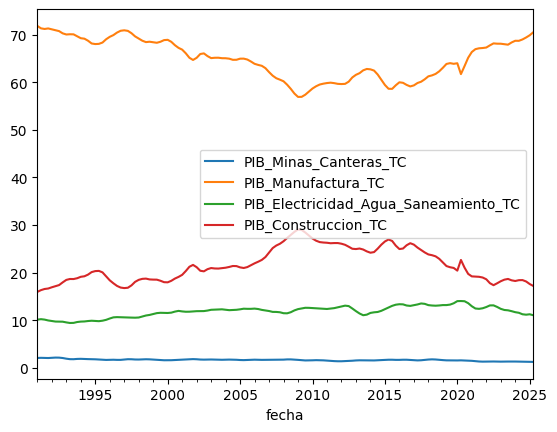

In [28]:
df_percentages = calculate_component_percentages(
    df = ob_pibv.oferta.get_industria_ampliada(),
    total_col = 'Industria_Ampliada_TC')

df_percentages.plot()

In [29]:
validate_percentage_sum(df_percentages)


✅ Percentage check: 138/138 rows within ±0.05 of 100.0.


{'n_total': 138,
 'n_valid': np.int64(138),
 'n_invalid': np.int64(0),
 'invalid_rows': [],
 'max_abs_deviation': 0.01}

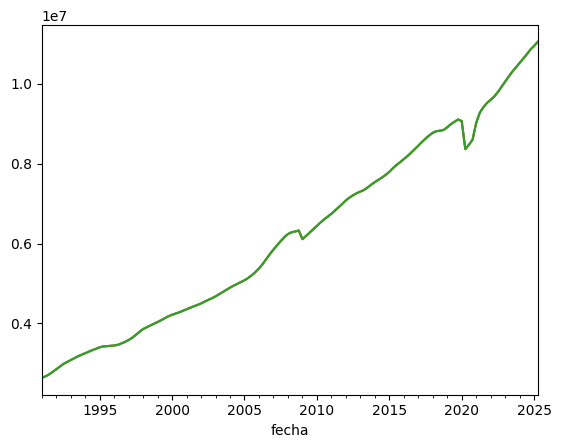

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1991-03-31 to 2025-06-30
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PIB_TC                 138 non-null    float64
 1   PIB_Valor_Agregado_TC  138 non-null    float64
 2   PIB_Impuestos_TC       138 non-null    float64
dtypes: float64(3)
memory usage: 4.3 KB


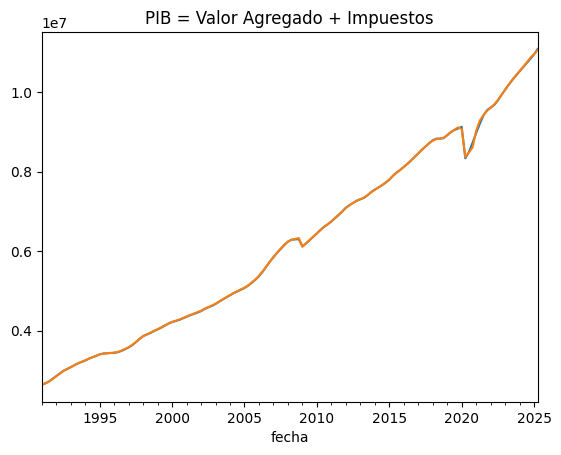

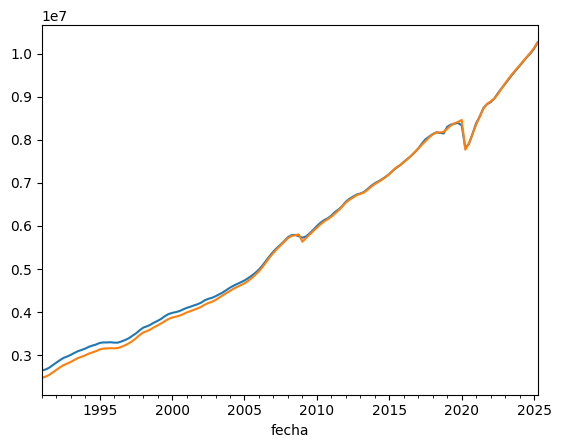

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1991-03-31 to 2025-06-30
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   PIB_Minas_Canteras_TC                 138 non-null    float64
 1   PIB_Manufactura_TC                    138 non-null    float64
 2   PIB_Electricidad_Agua_Saneamiento_TC  138 non-null    float64
 3   PIB_Construccion_TC                   138 non-null    float64
 4   Industria_Ampliada_TC                 138 non-null    float64
dtypes: float64(5)
memory usage: 6.5 KB


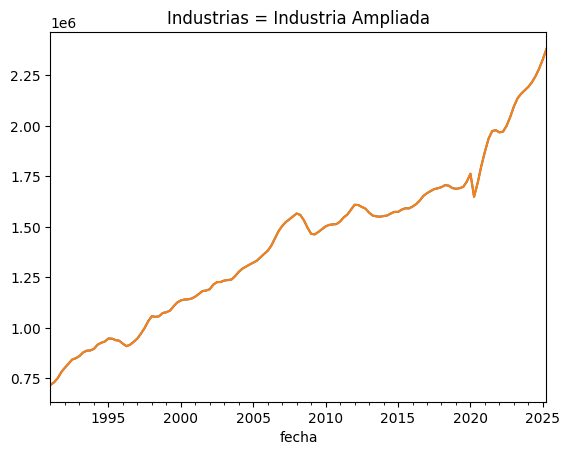

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1991-03-31 to 2025-06-30
Data columns (total 11 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PIB_Comercio_TC                      138 non-null    float64
 1   PIB_Transporte_Almacenamiento_TC     138 non-null    float64
 2   PIB_Hoteles_Restaurantes_TC          138 non-null    float64
 3   PIB_Informacion_Comunicaciones_TC    138 non-null    float64
 4   PIB_Financieras_Seguros_TC           138 non-null    float64
 5   PIB_Inmobiliario_TC                  138 non-null    float64
 6   PIB_Actividades_Profesionales_TC     138 non-null    float64
 7   PIB_Administracion_Publica_TC        138 non-null    float64
 8   PIB_Ense_Salud_Asistencia_Social_TC  138 non-null    float64
 9   PIB_Otras_Actividades_TC             138 non-null    float64
 10  Servicios_TC                         138 non-null    float64
dtypes: float64(11

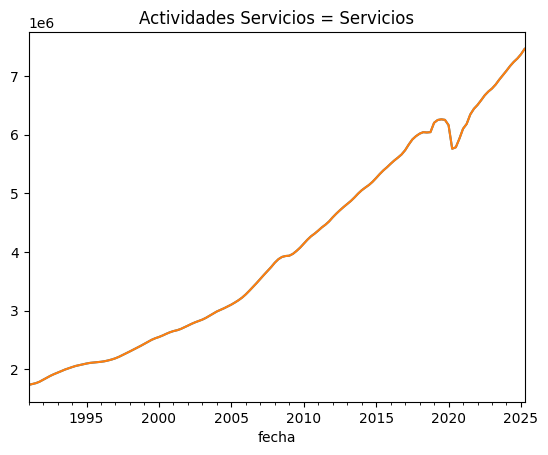

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1991-03-31 to 2025-06-30
Data columns (total 3 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   PIB_Importacion_Bienes_RegDef_TC  138 non-null    float64
 1   PIB_Combustibles_TC               138 non-null    float64
 2   PIB_Sin_Combustibles_TC           138 non-null    float64
dtypes: float64(3)
memory usage: 4.3 KB


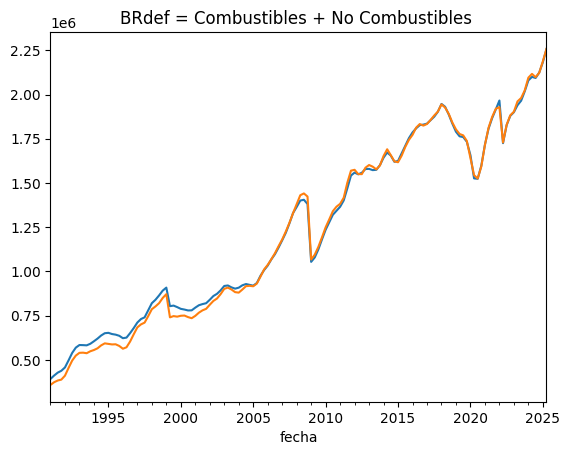

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1991-03-31 to 2025-06-30
Data columns (total 3 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   PIB_Importaciones_Bienes_TC       138 non-null    float64
 1   PIB_Importacion_Bienes_RegDef_TC  138 non-null    float64
 2   PIB_Importacion_Bienes_RegEsp_TC  138 non-null    float64
dtypes: float64(3)
memory usage: 4.3 KB


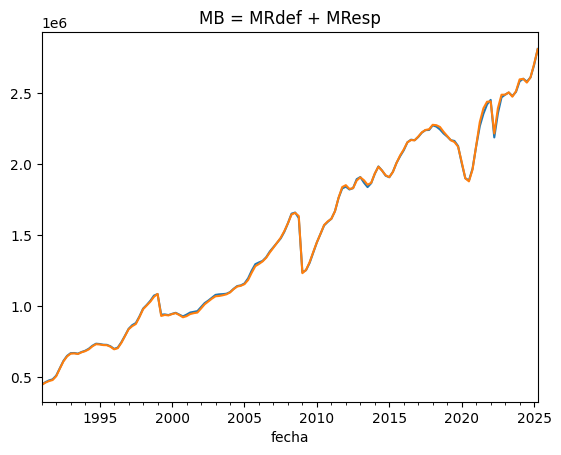

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1991-03-31 to 2025-06-30
Data columns (total 3 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   PIB_Importaciones_Bienes_Servicios_TC  138 non-null    float64
 1   PIB_Importaciones_Bienes_TC            138 non-null    float64
 2   PIB_Importaciones_Servicios_TC         138 non-null    float64
dtypes: float64(3)
memory usage: 4.3 KB


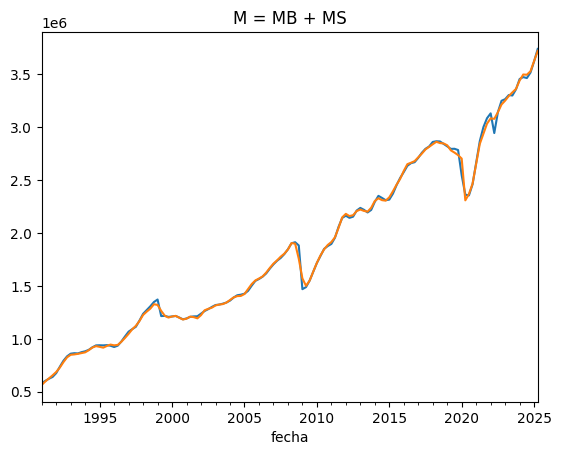

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1991-03-31 to 2025-06-30
Data columns (total 3 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   PIB_Exportaciones_Bienes_TC       138 non-null    float64
 1   PIB_Exportacion_Bienes_RegDef_TC  138 non-null    float64
 2   PIB_Exportacion_Bienes_RegEsp_TC  138 non-null    float64
dtypes: float64(3)
memory usage: 4.3 KB


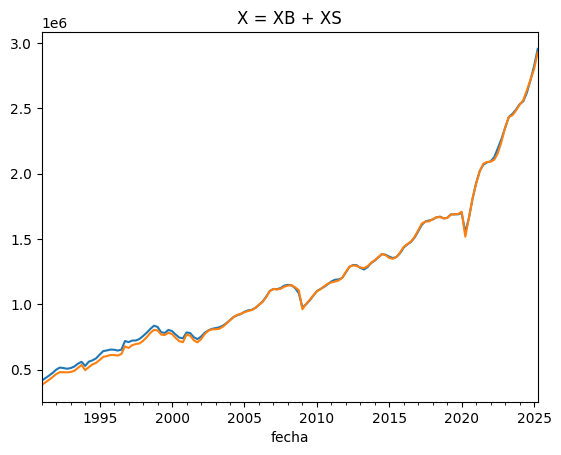

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1991-03-31 to 2025-06-30
Data columns (total 3 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   PIB_Exportaciones_Bienes_Servicios_TC  138 non-null    float64
 1   PIB_Exportaciones_Bienes_TC            138 non-null    float64
 2   PIB_Exportaciones_Servicios_TC         138 non-null    float64
dtypes: float64(3)
memory usage: 4.3 KB


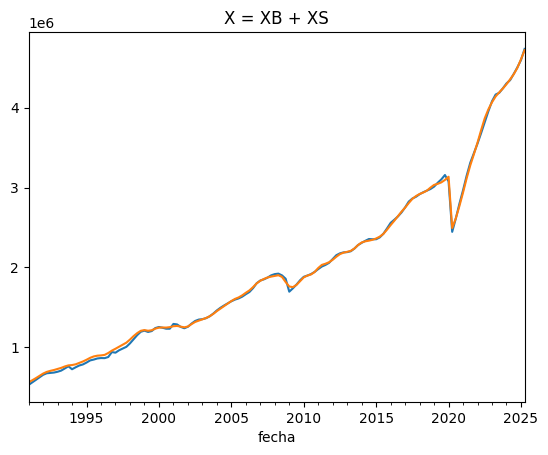

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1991-03-31 to 2025-06-30
Data columns (total 3 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   PIB_Formacion_Bruta_Capital_Fijo_TC  138 non-null    float64
 1   PIB_Maquinaria_Equipo_TC             138 non-null    float64
 2   PIB_Nuevas_Construcciones_TC         138 non-null    float64
dtypes: float64(3)
memory usage: 4.3 KB


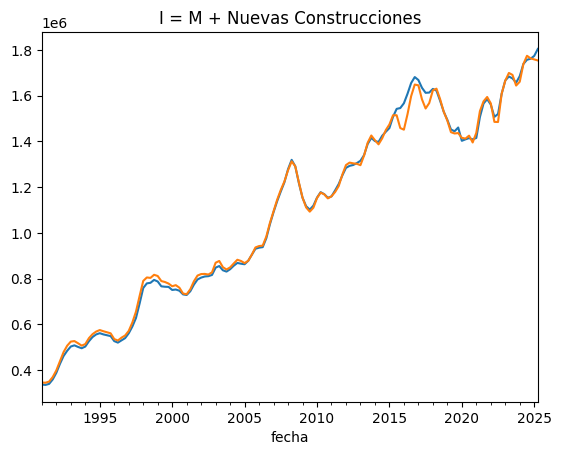

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1991-03-31 to 2025-06-30
Data columns (total 5 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   PIB_Gasto_Consumo_Final_Hogares_TC    138 non-null    float64
 1   PIB_Bienes_Consumo_Duradero_TC        138 non-null    float64
 2   PIB_Bienes_Consumo_Semi_Duraderos_TC  138 non-null    float64
 3   PIB_Bienes_Consumo_No_Duraderos_TC    138 non-null    float64
 4   PIB_Servicios_TC                      138 non-null    float64
dtypes: float64(5)
memory usage: 6.5 KB


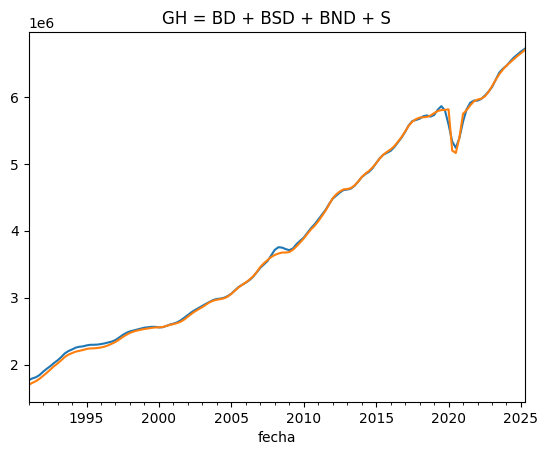

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1991-03-31 to 2025-06-30
Data columns (total 3 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   PIB_Gasto_Consumo_Final_TC                   138 non-null    float64
 1   PIB_Gasto_Consumo_Final_Hogares_TC           138 non-null    float64
 2   PIB_Gasto_Consumo_Final_Gobierno_General_TC  138 non-null    float64
dtypes: float64(3)
memory usage: 4.3 KB


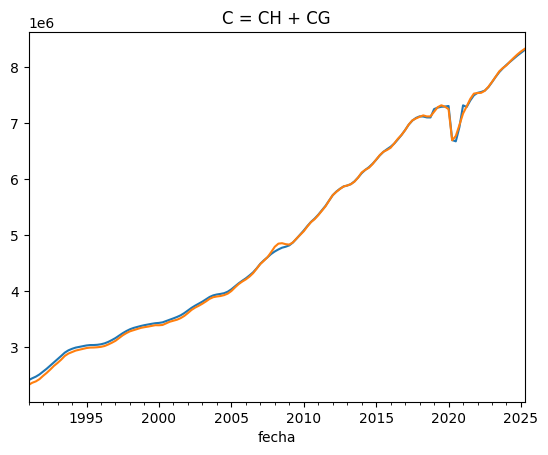

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1991-03-31 to 2025-06-30
Data columns (total 6 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   PIB_TC                                       138 non-null    float64
 1   PIB_Gasto_Consumo_Final_Hogares_TC           138 non-null    float64
 2   PIB_Gasto_Consumo_Final_Gobierno_General_TC  138 non-null    float64
 3   PIB_Formacion_Bruta_Capital_Fijo_TC          138 non-null    float64
 4   PIB_Exportaciones_Bienes_Servicios_TC        138 non-null    float64
 5   PIB_Importaciones_Bienes_Servicios_TC        138 non-null    float64
dtypes: float64(6)
memory usage: 7.5 KB


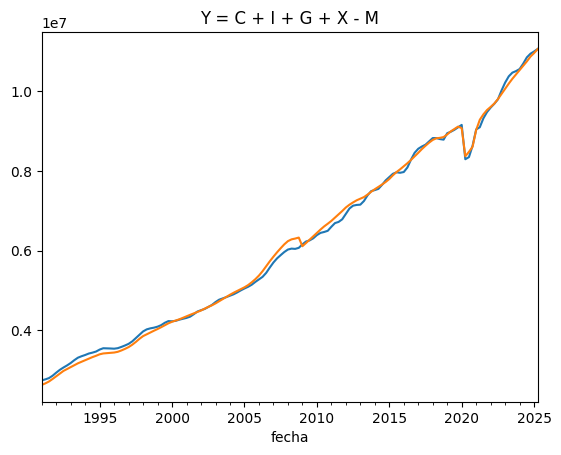

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 138 entries, 1991-03-31 to 2025-06-30
Data columns (total 3 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   PIB_Gasto_Consumo_Final_Hogares_TC           138 non-null    float64
 1   PIB_Gasto_Consumo_Final_Gobierno_General_TC  138 non-null    float64
 2   PIB_Formacion_Bruta_Capital_Fijo_TC          138 non-null    float64
dtypes: float64(3)
memory usage: 4.3 KB


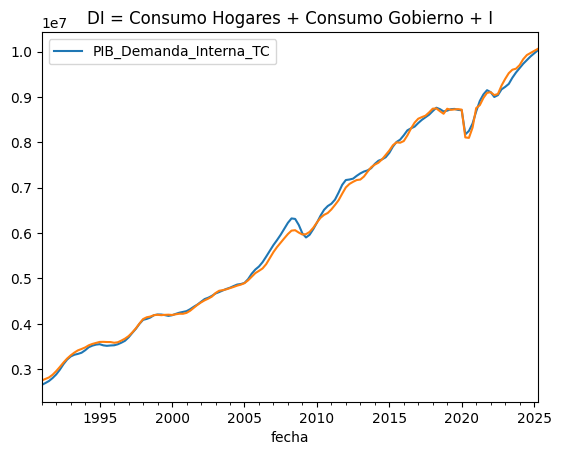

In [30]:
ob_pibv.demanda.get_categorias_principales()['PIB_TC'].plot()
ob_pibv.demanda.get_pib().squeeze().plot()
ob_pibv.oferta.get_pib().squeeze().plot()
plt.show()

#==============================================================================================================
# Validaciones de Oferta
#==============================================================================================================

# PIB = Valor Agregado + Impuestos 
tipo = '_TC'
ob_pibv = PIBViews(quarterly_data_levels_TC, series_type = tipo)
df = ob_pibv.oferta.get_categorias_principales()
df.info()
col_total = 'PIB' + tipo
df_2 = df.drop(col_total, axis = 1)
df_2.sum(axis = 1).plot()
df[col_total].plot()
plt.title('PIB = Valor Agregado + Impuestos')
plt.show()


tipo = '_TC'
ob_pibv = PIBViews(quarterly_data_levels_TC, series_type = tipo)
df1 = ob_pibv.oferta.get_industrias()
df1.sum(axis = 1).plot()
df2 = ob_pibv.oferta.get_valor_agregado().squeeze()
df2.plot()
plt.show()

tipo = '_TC'
ob_pibv = PIBViews(quarterly_data_levels_TC, series_type = tipo)
df = ob_pibv.oferta.get_industria_ampliada()
df.info()
col_total = 'Industria_Ampliada' + tipo
df_2 = df.drop(col_total, axis = 1)
df_2.sum(axis = 1).plot()
df[col_total].plot()
plt.title('Industrias = Industria Ampliada')
plt.show()

tipo = '_TC'
ob_pibv = PIBViews(quarterly_data_levels_TC, series_type = tipo)
df = ob_pibv.oferta.get_servicios()
df.info()
col_total = 'Servicios' + tipo
df_2 = df.drop(col_total, axis = 1)
df_2.sum(axis = 1).plot()
df[col_total].plot()
plt.title('Actividades Servicios = Servicios')
plt.show()

#==============================================================================================================
# Validaciones de Demanda
#==============================================================================================================


# validación MBRdef = Combustibles + No Combustibles 
tipo = '_TC'
ob_pibv = PIBViews(quarterly_data_levels_TC, series_type = tipo)
df = ob_pibv.demanda.get_importaciones_bienes_regimen_def()
df.info()
col_total = 'PIB_Importacion_Bienes_RegDef' + tipo
df_2 = df.drop(col_total, axis = 1)
df_2.sum(axis = 1).plot()
df[col_total].plot()
plt.title('BRdef = Combustibles + No Combustibles ')
plt.show()



# validación MB = MRdef + MResp 
tipo = '_TC'
ob_pibv = PIBViews(quarterly_data_levels_TC, series_type = tipo)
df = ob_pibv.demanda.get_importaciones_bienes()
df.info()
col_total = 'PIB_Importaciones_Bienes' + tipo
df_2 = df.drop(col_total, axis = 1)
df_2.sum(axis = 1).plot()
df[col_total].plot()
plt.title('MB = MRdef + MResp')
plt.show()


# validación M = MB + MS 
tipo = '_TC'
ob_pibv = PIBViews(quarterly_data_levels_TC, series_type = tipo)
df = ob_pibv.demanda.get_importaciones()
df.info()
col_total = 'PIB_Importaciones_Bienes_Servicios' + tipo
df_2 = df.drop(col_total, axis = 1)
df_2.sum(axis = 1).plot()
df[col_total].plot()
plt.title('M = MB + MS')
plt.show()


# validación XB = XB Rdeg + XS Resp
tipo = '_TC'
ob_pibv = PIBViews(quarterly_data_levels_TC, series_type = tipo)
df = ob_pibv.demanda.get_exportaciones_bienes()
df.info()
col_total = 'PIB_Exportaciones_Bienes' + tipo
df_2 = df.drop(col_total, axis = 1)
df_2.sum(axis = 1).plot()
df[col_total].plot()
plt.title('X = XB + XS')
plt.show()


# validación X = XB + XS
tipo = '_TC'
ob_pibv = PIBViews(quarterly_data_levels_TC, series_type = tipo)
df = ob_pibv.demanda.get_exportaciones()
df.info()
col_total = 'PIB_Exportaciones_Bienes_Servicios' + tipo
df_2 = df.drop(col_total, axis = 1)
df_2.sum(axis = 1).plot()
df[col_total].plot()
plt.title('X = XB + XS')
plt.show()


# validación I = Maquinaria + Nuevas Construcciones
tipo = '_TC'
ob_pibv = PIBViews(quarterly_data_levels_TC, series_type = tipo)
df = ob_pibv.demanda.get_inversion()
df.info()
col_total = 'PIB_Formacion_Bruta_Capital_Fijo' + tipo
df_2 = df.drop(col_total, axis = 1)
df_2.sum(axis = 1).plot()
df[col_total].plot()
plt.title('I = M + Nuevas Construcciones')
plt.show()


# validación CH = BD + BSD + BND + S
tipo = '_TC'
ob_pibv = PIBViews(quarterly_data_levels_TC, series_type = tipo)
df = ob_pibv.demanda.get_consumo_hogares()
df.info()
col_total = 'PIB_Gasto_Consumo_Final_Hogares' + tipo
df_2 = df.drop(col_total, axis = 1)
df_2.sum(axis = 1).plot()
df[col_total].plot()
plt.title('GH = BD + BSD + BND + S')
plt.show()


# validación Consumo Final = C Hogares + C Gobierno
tipo = '_TC'
ob_pibv = PIBViews(quarterly_data_levels_TC, series_type = tipo)
df = ob_pibv.demanda.get_consumo()
df.info()
col_total = 'PIB_Gasto_Consumo_Final' + tipo
df_2 = df.drop(col_total, axis = 1)
df_2.sum(axis = 1).plot()
df[col_total].plot()
plt.title('C = CH + CG')
plt.show()


# validación Y = C + I + G + X - M
tipo = '_TC'
ob_pibv = PIBViews(quarterly_data_levels_TC, series_type = tipo)
df = ob_pibv.demanda.get_categorias_principales()
df.info()
df_2 = df.drop('PIB' + tipo, axis = 1)
df_2['PIB_Importaciones_Bienes_Servicios' + tipo] = -1 * df_2['PIB_Importaciones_Bienes_Servicios' + tipo]
df_2.sum(axis = 1).plot()
df['PIB' + tipo].plot()
plt.title('Y = C + I + G + X - M')
plt.show()


# Validación: Demanda Intera = C + G + I
tipo = '_TC'
df1 = quarterly_data_levels_TC
ob_pibv = PIBViews(df1, series_type = tipo)
df = ob_pibv.demanda.get_demanda_interna()
df.info()
df1.filter(regex = C.DEMANDA_INTERNA + tipo).plot()
df.sum(axis = 1).plot()
plt.title('DI = Consumo Hogares + Consumo Gobierno + I')
plt.show()
